<ipython-input-78-f7804947921e>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno = plt.cm.get_cmap('inferno', 256)


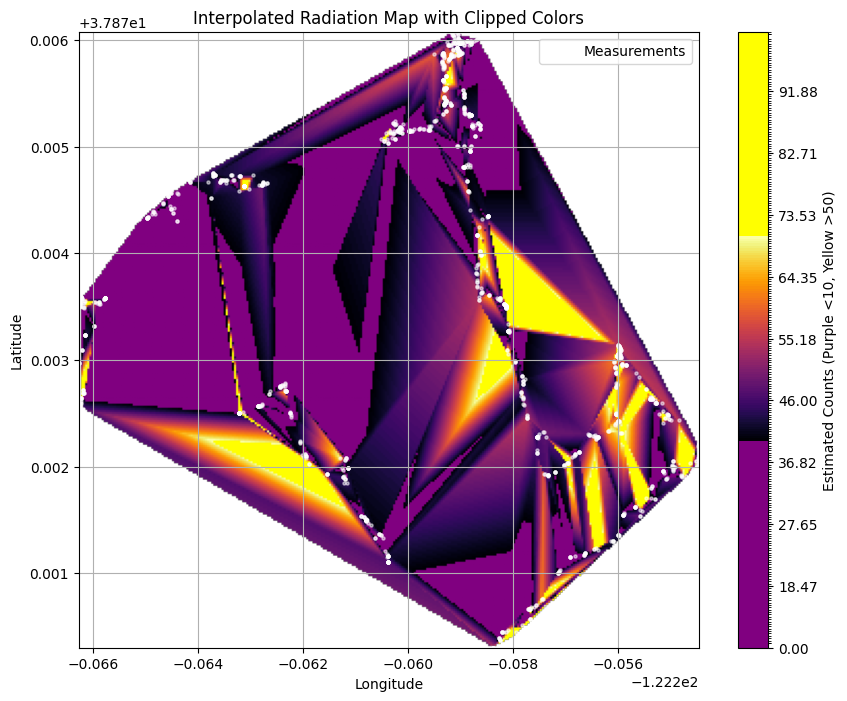

Map saved to '/content/berkeley_red_path_map.html'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

# Load and clean dataset
df = pd.read_csv('/content/Datamap2.csv')
df = df.dropna(subset=['Latitude', 'Longitude', 'counts'])

# Ensure numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['counts'] = pd.to_numeric(df['counts'], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude', 'counts'])

# Extract coordinates and counts
x = df['Longitude'].values
y = df['Latitude'].values
z = df['counts'].values

# Interpolation grid
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),
    np.linspace(y.min(), y.max(), 300)
)
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

# Define thresholds
clipped_min = 10
clipped_max = 100

# Prepare custom colormap
inferno = plt.cm.get_cmap('inferno', 256)
inferno_colors = inferno(np.linspace(0, 1, 256))

# Ensure purple and yellow have 4 columns, including an alpha channel (transparency)
purple = np.array([[128/255, 0/255, 128/255, 1]])  # Purple for below min, with alpha = 1
yellow = np.array([[1, 1, 0, 1]])  # Yellow for above max, with alpha = 1

# Expand purple and yellow to match the size of inferno_colors
purple_expanded = np.repeat(purple, inferno_colors.shape[0], axis=0)
yellow_expanded = np.repeat(yellow, inferno_colors.shape[0], axis=0)

# Combine arrays (purple, inferno gradient, and yellow)
custom_colors = np.vstack([purple_expanded, inferno_colors, yellow_expanded])

# Assemble final colormap
custom_cmap = ListedColormap(custom_colors)

# Define boundaries: below, within, above
bounds = np.concatenate((
    [0, clipped_min],
    np.linspace(clipped_min, clipped_max, 256),
    [clipped_max, z.max() + 1]
))
norm = BoundaryNorm(boundaries=bounds, ncolors=custom_cmap.N)

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.title("Interpolated Radiation Map with Clipped Colors")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.imshow(grid_z, extent=(x.min(), x.max(), y.min(), y.max()),
           origin='lower', cmap=custom_cmap, norm=norm, aspect='auto')
plt.colorbar(label='Estimated Counts (Purple <10, Yellow >50)')
plt.scatter(x, y, c='white', s=5, alpha=0.5, label='Measurements')
plt.legend()
plt.grid(True)
plt.show()

m.save('/content/berkeley_radiation_map_grid.html')
print("Map saved to '/content/berkeley_red_path_map.html'")

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium import Map, PolyLine

# Load and clean data
df = pd.read_csv('/content/Datamap2.csv')
df = df.dropna(subset=['Latitude', 'Longitude'])
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude'])

# Get coordinates as a list of (lat, lon) pairs
path_coords = list(zip(df['Latitude'], df['Longitude']))

# Center of map
center_lat = np.mean(df['Latitude'])
center_lon = np.mean(df['Longitude'])

# Create Folium map
m = Map(location=[center_lat, center_lon], zoom_start=16, tiles='cartodbpositron')

# Add red path line
PolyLine(locations=path_coords, color='red', weight=5, opacity=0.8).add_to(m)

# Save and display
m.save('/content/berkeley_red_path_map.html')
print("Map saved to '/content/berkeley_red_path_map.html'")
m


Map saved to '/content/berkeley_red_path_map.html'


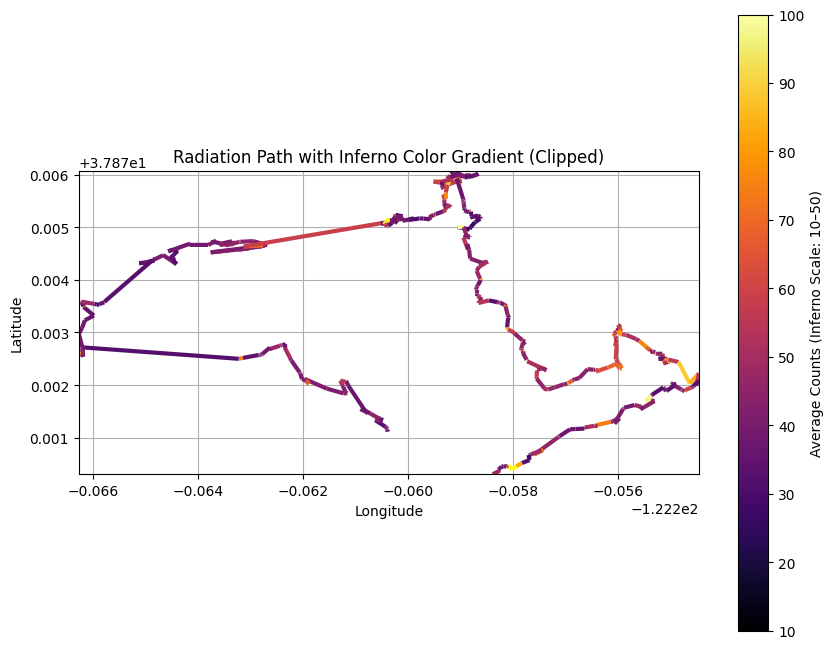

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

# Load and clean data
df = pd.read_csv('/content/Datamap2.csv')
df = df.dropna(subset=['Time', 'Latitude', 'Longitude', 'counts'])

# Ensure numeric
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['counts'] = pd.to_numeric(df['counts'], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude', 'counts'])

# Sort by time
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df = df.dropna(subset=['Time'])
df = df.sort_values('Time')

# Coordinates and counts
lat = df['Latitude'].values
lon = df['Longitude'].values
counts = df['counts'].values

# Create line segments and average counts
points = np.array([lon, lat]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
avg_counts = (counts[:-1] + counts[1:]) / 2

# Define count range and normalization
clipped_min = 10
clipped_max = 100
norm = Normalize(vmin=clipped_min, vmax=clipped_max)

# Get inferno colormap
inferno = plt.cm.inferno

# Assign colors: purple below, yellow above, inferno in between
colors = []
for val in avg_counts:
    if val < clipped_min:
        colors.append("purple")
    elif val > clipped_max:
        colors.append("yellow")
    else:
        colors.append(inferno(norm(val)))

# Create line collection
lc = LineCollection(segments, colors=colors, linewidth=3)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.add_collection(lc)
ax.scatter(lon, lat, c='white', s=3, alpha=0.3)

# Add colorbar with inferno gradient
sm = plt.cm.ScalarMappable(cmap=inferno, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Average Counts (Inferno Scale: 10–50)')

ax.set_title("Radiation Path with Inferno Color Gradient (Clipped)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
ax.set_aspect('equal', 'box')
ax.grid(True)
plt.show()

Map saved: /content/berkeley_radiation_map.html



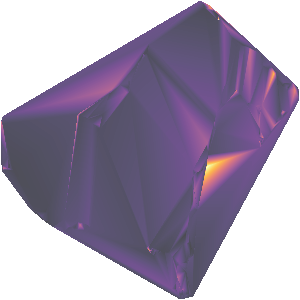

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from matplotlib import cm
import folium
import os

# Load and clean dataset
df = pd.read_csv('/content/Datamap2.csv')
df = df.dropna(subset=['Latitude', 'Longitude', 'counts'])

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['counts'] = pd.to_numeric(df['counts'], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude', 'counts'])

# Extract coordinates and counts
x = df['Longitude'].values
y = df['Latitude'].values
z = df['counts'].values

# Create grid to interpolate onto
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),
    np.linspace(y.min(), y.max(), 300)
)

# Interpolate using linear method (gradient-like)
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

# --- Save interpolated heatmap as transparent PNG ---
norm = Normalize(vmin=np.nanmin(grid_z), vmax=np.nanmax(grid_z))
cmap = cm.inferno
image = cmap(norm(grid_z))

# Make NaNs transparent
image[..., -1] = np.where(np.isnan(grid_z), 0, 0.7)

# Save the image to disk
overlay_path = '/content/radiation_overlay.png'
plt.imsave(overlay_path, image)

# --- Create Folium map centered on UC Berkeley ---
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=16, tiles='cartodbpositron')

# Define bounds for the overlay (same as grid)
img_bounds = [[y.min(), x.min()], [y.max(), x.max()]]

# Add image overlay
folium.raster_layers.ImageOverlay(
    name="Radiation Heatmap",
    image=overlay_path,
    bounds=img_bounds,
    opacity=0.7,
    interactive=True,
    cross_origin=False
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save map as HTML
output_html = '/content/berkeley_radiation_map.html'
m.save(output_html)
print(f"Map saved: {output_html}")
m

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium import Map, PolyLine
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib import cm

# Load and clean data
df = pd.read_csv('/content/Datamap2.csv')
df = df.dropna(subset=['Time', 'Latitude', 'Longitude', 'counts'])

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['counts'] = pd.to_numeric(df['counts'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude', 'counts', 'Time'])
df = df.sort_values('Time')

# Extract data
lat = df['Latitude'].values
lon = df['Longitude'].values
counts = df['counts'].values

# Create segments and compute average counts
segments = [
    {
        "coords": [(lat[i], lon[i]), (lat[i+1], lon[i+1])],
        "avg_count": (counts[i] + counts[i+1]) / 2
    }
    for i in range(len(lat) - 1)
]

# Clipping and normalization
clipped_min = 10
clipped_max = 100
norm = Normalize(vmin=clipped_min, vmax=clipped_max)
inferno = cm.get_cmap('inferno')

# Function to get color based on avg_count
def get_color(val):
    if val < clipped_min:
        return "purple"
    elif val > clipped_max:
        return "yellow"
    else:
        rgba = inferno(norm(val))
        return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]:.2f})'

# Initialize Folium map
center_lat = np.mean(lat)
center_lon = np.mean(lon)
m = Map(location=[center_lat, center_lon], zoom_start=16, tiles='cartodbpositron')

# Add segments with custom colors
for seg in segments:
    PolyLine(
        locations=seg["coords"],
        color=get_color(seg["avg_count"]),
        weight=5,
        opacity=0.8
    ).add_to(m)

# Save and display
m.save('/content/berkeley_radiation_path_map.html')
print("Map saved to '/content/berkeley_radiation_path_map.html'")
m


<ipython-input-71-0460462a1a23>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno = cm.get_cmap('inferno')


Map saved to '/content/berkeley_radiation_path_map.html'
